# Import Library

In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to C:\Users\Rafif Idris
[nltk_data]     Ardhana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rafif Idris
[nltk_data]     Ardhana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading Dataset

In [3]:
app_review_df = pd.read_csv("dataset_gopay_reviews.csv")
app_review_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,f4314250-83b1-4106-91ab-a7be95e533f3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,apalah saya udah lunasin pinjaman bayaran pert...,1,0,NaN,2025-03-28 11:19:23,"Hai Kak Irsan, mohon maaf atas kendala yang ka...",2025-03-28 11:51:07,NaN
1,3cf5e680-7cee-490c-9c05-e73f860720e8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mantap pokoknya,5,0,1.37.1,2025-03-28 11:19:03,NaN,NaN,1.37.1
2,06b948c4-b3e4-45c1-a72f-21e95dc9c032,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ngak jelas pinjaman bpkb kalian udah dua kali ...,1,0,1.43.0,2025-03-28 11:18:49,"Hai Kak Kiki, mohon maaf atas kendala yang kam...",2025-03-28 11:48:12,1.43.0
3,6d31cafa-01f2-40cc-b1c8-077abe2c50ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ada kendala pada pembayaran Qris tidak bisa di...,1,0,1.27.0,2025-03-28 11:12:09,"Hai Kak Rahmad, maaf atas ketidaknyamanannya. ...",2025-03-28 11:44:35,1.27.0
4,3943579a-ad84-4a34-97c1-13742e733aec,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus,5,0,1.44.0,2025-03-28 11:11:37,NaN,NaN,1.44.0


In [4]:
app_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212047 entries, 0 to 212046
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              212047 non-null  object
 1   userName              212047 non-null  object
 2   userImage             212047 non-null  object
 3   content               212046 non-null  object
 4   score                 212047 non-null  int64 
 5   thumbsUpCount         212047 non-null  int64 
 6   reviewCreatedVersion  178581 non-null  object
 7   at                    212047 non-null  object
 8   replyContent          35082 non-null   object
 9   repliedAt             35082 non-null   object
 10  appVersion            178581 non-null  object
dtypes: int64(2), object(9)
memory usage: 17.8+ MB


In [5]:
# Membentuk dataframe baru dan menghapus kolom Nan (Null)
clean_df = app_review_df.dropna()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26678 entries, 2 to 212046
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              26678 non-null  object
 1   userName              26678 non-null  object
 2   userImage             26678 non-null  object
 3   content               26678 non-null  object
 4   score                 26678 non-null  int64 
 5   thumbsUpCount         26678 non-null  int64 
 6   reviewCreatedVersion  26678 non-null  object
 7   at                    26678 non-null  object
 8   replyContent          26678 non-null  object
 9   repliedAt             26678 non-null  object
 10  appVersion            26678 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.4+ MB


In [6]:
# Mengecek duplikasi data
print("Jumlah duplikasi:", clean_df.duplicated().sum())

Jumlah duplikasi: 0


In [7]:
# Menghitung jumlah baris dan kolom
print(f"{clean_df.shape[0]} baris, {clean_df.shape[1]} kolom")

26678 baris, 11 kolom


# Preprocessing Data

In [8]:
# Fungsi untuk menghapus spesial karakter
def cleaningText(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # menghapus mentions
    text = re.sub(r"#[A-Za-z0-9]+", "", text) # menghapus hashtag
    text = re.sub(r"RT[\s]", "", text) # menghapus RT
    text = re.sub(r"http\S+", "", text) # menghapus link
    text = re.sub(r"[0-9]+", "", text) # menghapus angka
    text = re.sub(r"[^\w\s]", "", text) # menghapus karakter bukan huruf dan angka


    text = text.replace("\n", " ") # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans("", "", string.punctuation)) # menghapus tanda baca
    text = text.strip(" ") # membersihkan spasi yang tidak perlu di awal dan akhir teks
    return text

# Fungsi untuk mengonversi karakter ke dalam huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Fungsi untuk mengonversi karakter menjadi token (agar pengolahan lebih mudah)
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Fungsi untuk membersihkan teks dari kata umum
def filteringText(text):
    listStopwords = set(stopwords.words("indonesian"))
    listStopwords1 = set(stopwords.words("english"))
    listStopwords.update(listStopwords1)
    listStopwords.update(["iya","yaa","gak","nya","na","sih","ku","di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Fungsi untuk menyederhanakan kata-kata ke bentuk dasarnya
def stemmingText (text):
    # Inisialisasi stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# Fungsi untuk menggabungkan daftar kata menjadi satu kalimat
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [9]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual","wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [10]:
cleaned_df = clean_df.copy()

In [11]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
cleaned_df["text_clean"] = cleaned_df["content"].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
cleaned_df["text_casefoldingText"] = cleaned_df["text_clean"].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
cleaned_df["text_slangwords"] = cleaned_df["text_casefoldingText"].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
cleaned_df["text_tokenizingText"] = cleaned_df["text_slangwords"].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
cleaned_df["text_stopword"] = cleaned_df["text_tokenizingText"].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
cleaned_df["text_akhir"] = cleaned_df["text_stopword"].apply(toSentence)

In [12]:
cleaned_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
2,06b948c4-b3e4-45c1-a72f-21e95dc9c032,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ngak jelas pinjaman bpkb kalian udah dua kali ...,1,0,1.43.0,2025-03-28 11:18:49,"Hai Kak Kiki, mohon maaf atas kendala yang kam...",2025-03-28 11:48:12,1.43.0,ngak jelas pinjaman bpkb kalian udah dua kali ...,ngak jelas pinjaman bpkb kalian udah dua kali ...,ngak jelas pinjaman bpkb kalian sudah dua kali...,"[ngak, jelas, pinjaman, bpkb, kalian, sudah, d...","[ngak, pinjaman, bpkb, kali, menentu, penjempu...",ngak pinjaman bpkb kali menentu penjemputan do...
3,6d31cafa-01f2-40cc-b1c8-077abe2c50ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ada kendala pada pembayaran Qris tidak bisa di...,1,0,1.27.0,2025-03-28 11:12:09,"Hai Kak Rahmad, maaf atas ketidaknyamanannya. ...",2025-03-28 11:44:35,1.27.0,ada kendala pada pembayaran Qris tidak bisa di...,ada kendala pada pembayaran qris tidak bisa di...,ada kendala pada pembayaran qris tidak bisa di...,"[ada, kendala, pada, pembayaran, qris, tidak, ...","[kendala, pembayaran, qris, dikirim, kendala, ...",kendala pembayaran qris dikirim kendala aktivi...
8,304f46f3-415b-4d4e-88d2-df9888520fe9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Apa pertama masuk bisa top Up free Fire gratis?,3,0,1.44.0,2025-03-28 10:43:42,"Hai Kak Naufal, mohon maaf atas ketidaknyamana...",2025-03-28 11:24:19,1.44.0,Apa pertama masuk bisa top Up free Fire gratis,apa pertama masuk bisa top up free fire gratis,apa pertama masuk bisa top up free fire gratis,"[apa, pertama, masuk, bisa, top, up, free, fir...","[masuk, top, free, fire, gratis]",masuk top free fire gratis
14,d8954d0e-68a7-4a5c-86c6-c9d576805b8c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasinya suka ngebug. saat tup up game pada...,1,0,1.44.0,2025-03-28 10:15:41,"Hai Kak @Gak Punya Ayang, mohon maaf atas keti...",2025-03-28 11:17:50,1.44.0,aplikasinya suka ngebug saat tup up game padah...,aplikasinya suka ngebug saat tup up game padah...,aplikasinya suka ngebug saat tup up game padah...,"[aplikasinya, suka, ngebug, saat, tup, up, gam...","[aplikasinya, suka, ngebug, tup, game, pembaya...",aplikasinya suka ngebug tup game pembayaran se...
28,739fa1ba-6e56-4915-9eb6-ac45947f3343,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"kadang aplikasinya aneh, mau bayar pake qr mal...",4,0,1.44.0,2025-03-28 08:57:28,"Hai Kak Dira, maaf atas ketidaknyamanannya. Pa...",2025-03-28 07:10:32,1.44.0,kadang aplikasinya aneh mau bayar pake qr mala...,kadang aplikasinya aneh mau bayar pake qr mala...,kadang aplikasinya aneh mau bayar pakai qr bah...,"[kadang, aplikasinya, aneh, mau, bayar, pakai,...","[kadang, aplikasinya, aneh, bayar, pakai, qr, ...",kadang aplikasinya aneh bayar pakai qr tulisan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212036,a0546921-e2b6-4148-bfc1-81acc2147ffc,Gula Jawa,https://play-lh.googleusercontent.com/a/ACg8oc...,Kenapa ga bisa langsung masuk ke dalam gopay si,2,1,1.0.0,2023-04-09 20:51:28,"Hai, saat ini aplikasi GoPay masih berada dala...",2023-04-10 11:48:47,1.0.0,Kenapa ga bisa langsung masuk ke dalam gopay si,kenapa ga bisa langsung masuk ke dalam gopay si,kenapa ga bisa langsung masuk ke dalam gopay si,"[kenapa, ga, bisa, langsung, masuk, ke, dalam,...","[langsung, masuk, gopay, si]",langsung masuk gopay si
212038,ddab463c-24fb-49bb-bb52-b0dff2ab7bd7,Gilang Fauzi,https://play-lh.googleusercontent.com/a-/ALV-U...,Bagus tutup aja gk bagus Pakai antrian lagi le...,1,5,1.0.0,2023-04-09 17:15:15,"Hai Gilang, saat ini gopay masih dalam versi p...",2023-04-10 11:56:47,1.0.0,Bagus tutup aja gk bagus Pakai antrian lagi le...,bagus tutup aja gk bagus pakai antrian lagi le...,bagus tutup saja gk bagus pakai antrian lagi l

# Labeling

In [13]:
import csv
import requests
from io import StringIO

# Loads positive lexicon data dari GitHub
# Inisiasi data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

# Mengirim permintaan HTTP untuk mendapatkan lexicon positive file CSV dari GitHub
response = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv")

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data dari GitHub
# Inisiasi data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

# Mengirim permintaan HTTP untuk mendapatkan lexicon negative file CSV dari GitHub
response = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv")

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [14]:
# Fungsi untuk menentukan polaritas sentimen dari ulasan aplikasi

def sentiment_analysis_lexicon_indonesia(text):
    # Inisialisasi skor sentimen ke 0
    score = 0

    # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    # Inisialisasi variabel polaritas
    polarity=''

    if (score >= 0):
        polarity = "positive"
    elif (score < -2):
        polarity = "negative"
    else:
        polarity = "neutral"

    return score, polarity

In [15]:
results = cleaned_df["text_stopword"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
cleaned_df["polarity_score"] = results[0]
cleaned_df["polarity"] = results[1]
print(cleaned_df["polarity"].value_counts())

polarity
positive    12659
negative    10773
neutral      3246
Name: count, dtype: int64


In [16]:
cleaned_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
2,06b948c4-b3e4-45c1-a72f-21e95dc9c032,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ngak jelas pinjaman bpkb kalian udah dua kali ...,1,0,1.43.0,2025-03-28 11:18:49,"Hai Kak Kiki, mohon maaf atas kendala yang kam...",2025-03-28 11:48:12,1.43.0,ngak jelas pinjaman bpkb kalian udah dua kali ...,ngak jelas pinjaman bpkb kalian udah dua kali ...,ngak jelas pinjaman bpkb kalian sudah dua kali...,"[ngak, jelas, pinjaman, bpkb, kalian, sudah, d...","[ngak, pinjaman, bpkb, kali, menentu, penjempu...",ngak pinjaman bpkb kali menentu penjemputan do...,-2,neutral
3,6d31cafa-01f2-40cc-b1c8-077abe2c50ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ada kendala pada pembayaran Qris tidak bisa di...,1,0,1.27.0,2025-03-28 11:12:09,"Hai Kak Rahmad, maaf atas ketidaknyamanannya. ...",2025-03-28 11:44:35,1.27.0,ada kendala pada pembayaran Qris tidak bisa di...,ada kendala pada pembayaran qris tidak bisa di...,ada kendala pada pembayaran qris tidak bisa di...,"[ada, kendala, pada, pembayaran, qris, tidak, ...","[kendala, pembayaran, qris, dikirim, kendala, ...",kendala pembayaran qris dikirim kendala aktivi...,2,positive
8,304f46f3-415b-4d4e-88d2-df9888520fe9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Apa pertama masuk bisa top Up free Fire gratis?,3,0,1.44.0,2025-03-28 10:43:42,"Hai Kak Naufal, mohon maaf atas ketidaknyamana...",2025-03-28 11:24:19,1.44.0,Apa pertama masuk bisa top Up free Fire gratis,apa pertama masuk bisa top up free fire gratis,apa pertama masuk bisa top up free fire gratis,"[apa, pertama, masuk, bisa, top, up, free, fir...","[masuk, top, free, fire, gratis]",masuk top free fire gratis,9,positive
14,d8954d0e-68a7-4a5c-86c6-c9d576805b8c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasinya suka ngebug. saat tup up game pada...,1,0,1.44.0,2025-03-28 10:15:41,"Hai Kak @Gak Punya Ayang, mohon maaf atas keti...",2025-03-28 11:17:50,1.44.0,aplikasinya suka ngebug saat tup up game padah...,aplikasinya suka ngebug saat tup up game padah...,aplikasinya suka ngebug saat tup up game padah...,"[aplikasinya, suka, ngebug, saat, tup, up, gam...","[aplikasinya, suka, ngebug, tup, game, pembaya...",aplikasinya suka ngebug tup game pembayaran se...,2,positive
28,739fa1ba-6e56-4915-9eb6-ac45947f3343,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"kadang aplikasinya aneh, mau bayar pake qr mal...",4,0,1.44.0,2025-03-28 08:57:28,"Hai Kak Dira, maaf atas ketidaknyamanannya. Pa...",2025-03-28 07:10:32,1.44.0,kadang aplikasinya aneh mau bayar pake qr mala...,kadang aplikasinya aneh mau bayar pake qr mala...,kadang aplikasinya aneh mau bayar pakai qr bah...,"[kadang, aplikasinya, aneh, mau, bayar, pakai,...","[kadang, aplikasinya, aneh, bayar, pakai, qr, ...",kadang aplikasinya aneh bayar pakai qr tulisan...,5,positive


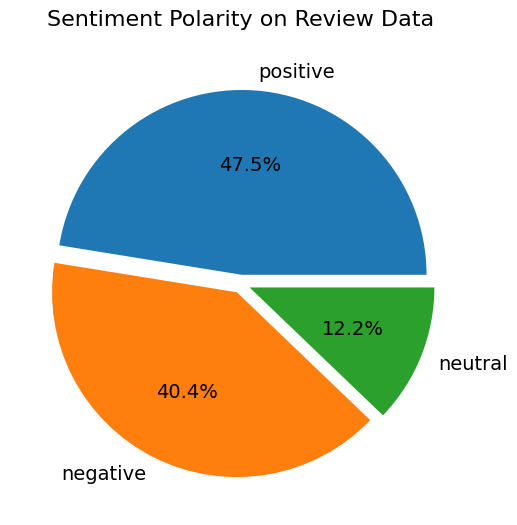

In [17]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in cleaned_df["polarity"].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'labels'.
labels = list(cleaned_df["polarity"].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = (0.05, 0.05, 0.05)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title("Sentiment Polarity on Review Data", fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [18]:
# Membuat DataFrame baru 'positive_reviews' yang hanya berisi ulasan dengan polaritas positif.

pd.set_option("display.max_colwidth", 3000)
positive_reviews = cleaned_df[cleaned_df["polarity"] == "positive"]
positive_reviews = positive_reviews[["text_akhir", "polarity_score", "polarity", "text_stopword"]]
positive_reviews = positive_reviews.sort_values(by="polarity_score", ascending=False)
positive_reviews = positive_reviews.reset_index(drop=True)
positive_reviews.index += 1

In [19]:
# Membuat DataFrame baru 'negative_reviews' yang hanya berisi ulasan dengan polaritas negatif.

pd.set_option("display.max_colwidth", 3000)
negative_reviews = cleaned_df[cleaned_df["polarity"] == "negative"]
negative_reviews = negative_reviews[["text_akhir", "polarity_score", "polarity", "text_stopword"]]
negative_reviews = negative_reviews.sort_values(by="polarity_score", ascending=True)
negative_reviews = negative_reviews[0:10]
negative_reviews = negative_reviews.reset_index(drop=True)
negative_reviews.index += 1

In [20]:
# Membuat DataFrame baru 'neutral_reviews' yang hanya berisi ulasan dengan polaritas netral.

pd.set_option("display.max_colwidth", 3000)
neutral_reviews = cleaned_df[cleaned_df["polarity"] == "neutral"]
neutral_reviews = neutral_reviews[["text_akhir", "polarity_score", "polarity", "text_stopword"]]
neutral_reviews = neutral_reviews.sort_values(by="polarity_score", ascending=False)
neutral_reviews = neutral_reviews.reset_index(drop=True)
neutral_reviews.index += 1

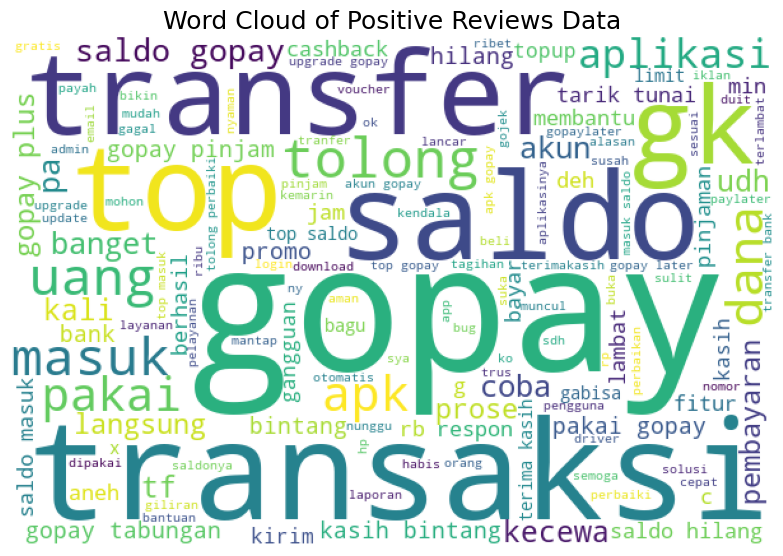

In [21]:
# Membuat string kosong 'list_words' untuk review positif
list_words = ""

for tweet in positive_reviews["text_stopword"]:
    for word in tweet:
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan tata letak untuk word cloud.
ax.set_title("Word Cloud of Positive Reviews Data", fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

# Menampilkan word cloud.
plt.show()

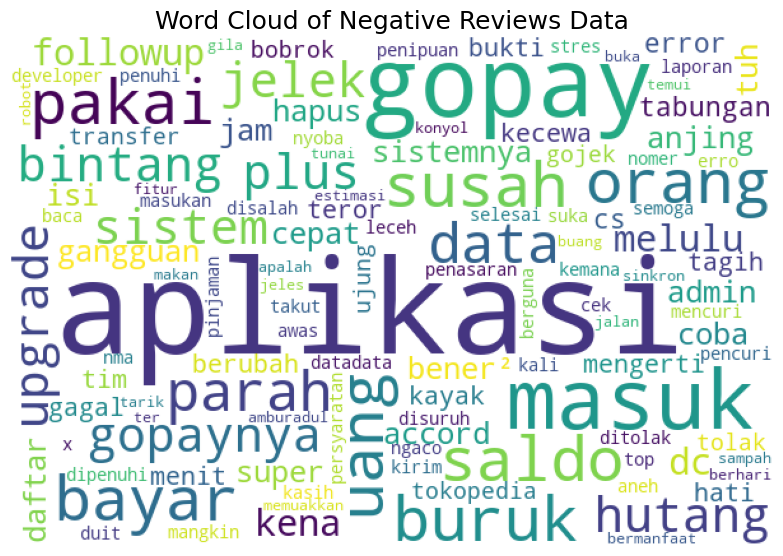

In [22]:
# Membuat string kosong 'list_words' untuk review negatif
list_words = ""

for tweet in negative_reviews["text_stopword"]:
    for word in tweet:
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan tata letak untuk word cloud.
ax.set_title("Word Cloud of Negative Reviews Data", fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

# Menampilkan word cloud.
plt.show()

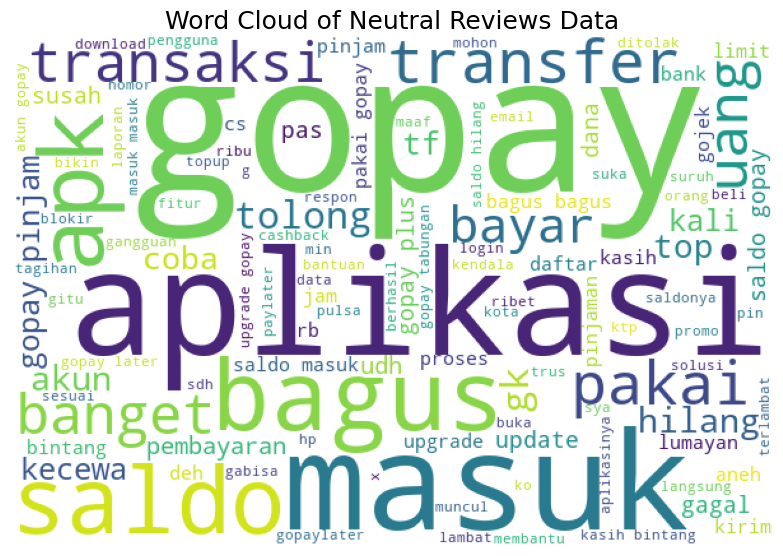

In [23]:
# Membuat string kosong 'list_words' untuk review netral
list_words = ""

for tweet in neutral_reviews["text_stopword"]:
    for word in tweet:
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan tata letak untuk word cloud.
ax.set_title("Word Cloud of Neutral Reviews Data", fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

# Menampilkan word cloud.
plt.show()

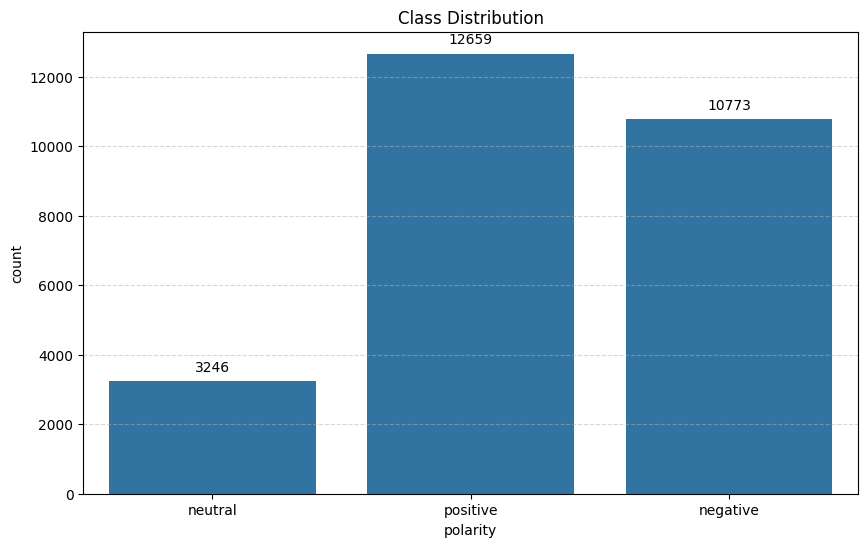

In [24]:
# Visualisasi Distribusi Polarity

plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x="polarity", data=cleaned_df)
plt.title("Class Distribution")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

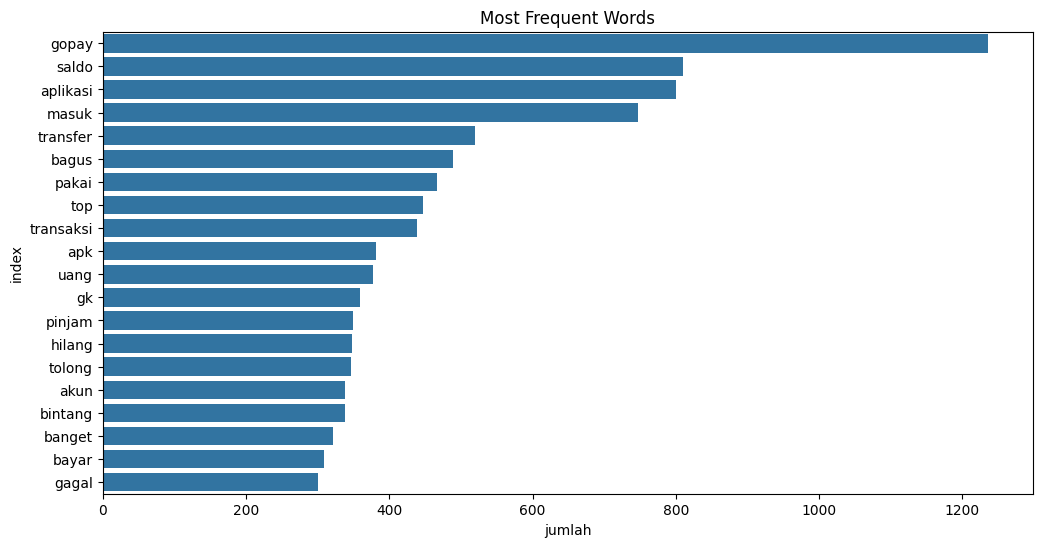

In [25]:
# Visualisasi Kata-Kata Paling Sering Muncul

from sklearn.feature_extraction.text import TfidfVectorizer

plt.figure(figsize=(12, 6))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_df["text_akhir"])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name="jumlah")
tfidf_df = tfidf_df.sort_values("jumlah", ascending=False).head(20)
sns.barplot(x="jumlah", y="index", data=tfidf_df)
plt.title("Most Frequent Words")
plt.show()

# Modeling

In [26]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
cleaned_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
2,06b948c4-b3e4-45c1-a72f-21e95dc9c032,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,ngak jelas pinjaman bpkb kalian udah dua kali saya menentu kan penjemputan dokumen dan tidak beraktifitas selalu ngak jadi apa kah itu tidak merugi kan seseorang.kalau mau yanh jelas aja dan pasti pasti aja...,1,0,1.43.0,2025-03-28 11:18:49,"Hai Kak Kiki, mohon maaf atas kendala yang kamu alami terkait GoPay Pinjam BPKB. Agar masalahnya dapat segera kami bantu, silakan ceritakan lebih lanjut kepada kami melalui email ke support@findaya.com dan cantumkan kode psr-25-087-0447-50697 di subjek email, ya. ^Maura",2025-03-28 11:48:12,1.43.0,ngak jelas pinjaman bpkb kalian udah dua kali saya menentu kan penjemputan dokumen dan tidak beraktifitas selalu ngak jadi apa kah itu tidak merugi kan seseorangkalau mau yanh jelas aja dan pasti pasti aja,ngak jelas pinjaman bpkb kalian udah dua kali saya menentu kan penjemputan dokumen dan tidak beraktifitas selalu ngak jadi apa kah itu tidak merugi kan seseorangkalau mau yanh jelas aja dan pasti pasti aja,ngak jelas pinjaman bpkb kalian sudah dua kali saya menentu kan penjemputan dokumen dan tidak beraktifitas selalu ngak jadi apa kah itu tidak merugi kan seseorangkalau mau yanh jelas saja dan pasti pasti saja,"[ngak, jelas, pinjaman, bpkb, kalian, sudah, dua, kali, saya, menentu, kan, penjemputan, dokumen, dan, tidak, beraktifitas, selalu, ngak, jadi, apa, kah, itu, tidak, merugi, kan, seseorangkalau, mau, yanh, jelas, saja, dan, pasti, pasti, saja]","[ngak, pinjaman, bpkb, kali, menentu, penjemputan, dokumen, beraktifitas, ngak, merugi, seseorangkalau, yanh]",ngak pinjaman bpkb kali menentu penjemputan dokumen beraktifitas ngak merugi seseorangkalau yanh,-2,neutral
3,6d31cafa-01f2-40cc-b1c8-077abe2c50ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,ada kendala pada pembayaran Qris tidak bisa dikirim karena ada kendala aktivitas gak wajar sudah di tunggu masih saja tidak bisa dan sudah saya update masih saja tidak bisa mohon di perbaiki lagi dan saat di telfon untuk meminta bantuan kendala tidak ada yang merespon,1,0,1.27.0,2025-03-28 11:12:09,"Hai Kak Rahmad, maaf atas ketidaknyamanannya. Pastikan kamu menggunakan aplikasi GoPay versi terbaru dan kode QR yang dipindai berasal dari merchant yang menerima pembayaran melalui kode GoPay. Jika masih berkendala, laporkan melalui email ke customerservice@gopay.co.id dan cantumkan kode psr-25-087-0444-29447 pada subjek email. ^Maura",2025-03-28 11:44:35,1.27.0,ada kendala pada pembayaran Qris tidak bisa dikirim karena ada kendala aktivitas gak wajar sudah di tunggu masih saja tidak bisa dan sudah saya update masih saja tidak bisa mohon di perbaiki lagi dan saat di telfon untuk meminta bantuan kendala tidak ada yang merespon,ada kendala pada pembayaran qris tidak bisa dikirim karena ada kendala aktivitas gak wajar sudah di tunggu masih saja tidak bisa dan sudah saya update masih saja tidak bisa mohon di perbaiki lagi dan saat di telfon untuk meminta bantuan kendala tidak ada yang merespon,ada kendala pada pembayaran qris tidak bisa dikirim karena ada kendala aktivitas gak wajar sudah di tunggu masih saja tidak bisa dan sudah saya update masih saja tidak bisa mohon di perbaiki lagi dan saat di telfon untuk meminta bantuan kendala tidak ada yang merespon,"[ada, kendala, pada, pembayaran, qris, tidak, bisa, dikirim, karena, ada, kendala, aktivitas, gak, wajar, sudah, di, tunggu, masih, saja, tidak, bisa, dan, sudah, saya, update, masih, saja, tidak, bisa, mohon, di, perbaiki, lagi, dan, saat, di, telfon, untuk, meminta, bantuan, kendala, tidak, ada, yang, merespon

In [28]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = cleaned_df["text_akhir"]
y = cleaned_df["polarity"]

In [29]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,aa,aaaagh,aad,aada,aah,aahh,aaja,aakun,aamiin,aamiinjangan,...,𝒎𝒂𝒔𝒖𝒌,𝒏𝒚𝒂,𝒏𝒚𝒐𝒃𝒂𝒊𝒏,𝒑𝒂𝒌𝒆,𝒑𝒂𝒔,𝒔𝒂𝒍𝒅𝒐,𝒔𝒂𝒏𝒈𝒂𝒕,𝒕𝒐𝒑,𝒖𝒑,𝘉𝘢𝘨𝘶𝘴
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Skema 1
**Pelatihan:** SVM, **Ekstrasi Fitur:** TF-ID, **Pembagian Data:** 80/20

In [30]:
# Bagi data menjadi data latih dan data uji
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [31]:
# Inisiasi model Support Vector Machine
svm = SVC(kernel="linear", C=2.0)

svm.fit(X_train_svm, y_train_svm)

y_pred_train_svm = svm.predict(X_train_svm.toarray())
y_pred_test_svm = svm.predict(X_test_svm.toarray())

accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train_svm)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test_svm)

# Menampilkan akurasi
print(f"Support Vector Machine - Accuracy Train: {accuracy_train_svm:.2f}")
print(f"Support Vector Machine - Accuracy Test: {accuracy_test_svm:.2f}")

Support Vector Machine - Accuracy Train: 0.96
Support Vector Machine - Accuracy Test: 0.87


## Skema 2
**Pelatihan:** LR, **Ekstrasi Fitur:** TF-ID, **Pembagian Data:** 70/30

In [32]:
# Bagi data menjadi data latih dan data uji
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [33]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train_lr, y_train_lr)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train_lr.toarray())
y_pred_test_lr = logistic_regression.predict(X_test_lr.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train_lr)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test_lr)

# Menampilkan akurasi
print(f"Logistic Regression - Accuracy Train: {accuracy_train_lr:.2f}")
print(f"Logistic Regression - Accuracy Test: {accuracy_test_lr:.2f}")

Logistic Regression - Accuracy Train: 0.89
Logistic Regression - Accuracy Test: 0.85


## Skema 3
**Pelatihan:** LSTM, **Pembagian Data:** 80/20

In [34]:
# Encode labels
label_encoder = LabelEncoder()
cleaned_df["sentiment_encoded"] = label_encoder.fit_transform(cleaned_df["polarity"])

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_df["text_akhir"])

# Mengonversi teks ke sequences
sequences = tokenizer.texts_to_sequences(cleaned_df["text_akhir"])
padded_sequences = pad_sequences(sequences, maxlen=100, padding="post", truncating="post")

# Bagi data menjadi data latih dan data uji
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(padded_sequences, cleaned_df["sentiment_encoded"], test_size=0.2, random_state=42, stratify=cleaned_df["sentiment_encoded"])

# Membangun LSTM model
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64,activation="relu"),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile model
model_lstm.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callback stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Melatih model LSTM
history = model_lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=20, batch_size=128, callbacks=[early_stopping])

# Evaluasi model LSTM
accuracy_train_lstm = history.history["accuracy"][-1]
loss, accuracy_test_lstm = model_lstm.evaluate(X_test_lstm, y_test_lstm)

# Menampilkan akurasi
print(f"Long Short Term Memory - Accuracy Train: {accuracy_train_lstm:.2f}")
print(f"Long Short Term Memory - Accuracy Test: {accuracy_test_lstm:.2f}")

Epoch 1/20


c:\Users\Rafif Idris Ardhana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


167/167 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.5378 - loss: 0.9227 - val_accuracy: 0.8199 - val_loss: 0.4477
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - accuracy: 0.8554 - loss: 0.3682 - val_accuracy: 0.8739 - val_loss: 0.3254
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 44s 265ms/step - accuracy: 0.9194 - loss: 0.2212 - val_accuracy: 0.8862 - val_loss: 0.2990
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - accuracy: 0.9399 - loss: 0.1686 - val_accuracy: 0.8780 - val_loss: 0.3269
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 49s 292ms/step - accuracy: 0.9558 - loss: 0.1365 - val_accuracy: 0.8936 - val_loss: 0.3625
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - accuracy: 0.9662 - loss: 0.1041 - val_accuracy: 0.8907 - val_loss: 0.3475
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8879 - loss: 0.2957
Long Short Term Memory - Accuracy Train: 0.97
Long Short Term Memory - Accuracy Test: 0.89


In [35]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    "Model": ["Support Vector Machine", "Logistic Regression", "Long Short Term Memory"],
    "Accuracy Train": [accuracy_train_svm, accuracy_train_lr, accuracy_train_lstm],
    "Accuracy Test": [accuracy_test_svm, accuracy_test_lr, accuracy_test_lstm]
})

results_df

,Model,Accuracy Train,Accuracy Test
0,Support Vector Machine,0.960875,0.870877
1,Logistic Regression,0.891186,0.851574
2,Long Short Term Memory,0.965327,0.886244


In [36]:
# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = results_df.sort_values(by='Accuracy Test', ascending=False)
accuracy_test_sorted

,Model,Accuracy Train,Accuracy Test
2,Long Short Term Memory,0.965327,0.886244
0,Support Vector Machine,0.960875,0.870877
1,Logistic Regression,0.891186,0.851574


**Insights**
- **Model LSTM** memiliki akurasi train 0.965 **(97%)** dan akurasi test 0.886 **(89%)**
- **Model SVM** memiliki akurasi train 0.960 **(96%)** dan akurasi test 0.870 **(87%)**
- **Mode LR** memiliki akurasi train 0.891 **(89%)** dan akurasi test 0.851 **(85%)**

# Inference

In [37]:
import numpy as np
import pickle
from keras.models import load_model

## Model Support Vector Machine
Kata yang akan digunakan sebagai testing:
**"Berhasil dan cepat untuk transfer gopay nya, desain aplikasi juga bagus"**.
Seharusnya ulasan ini berlabel **Positif**

In [38]:
def predict_sentiment_svm(text):
    # Preprocessing teks
    cleaned_text = cleaningText(text)
    casefolded_text = casefoldingText(cleaned_text)
    slangfixed_text = fix_slangwords(casefolded_text)
    tokenized_text = tokenizingText(slangfixed_text)
    filtered_text = filteringText(tokenized_text)
    final_text = toSentence(filtered_text)

    # Transformasi dengan TF-IDF
    X_text = tfidf.transform([final_text])

    # Prediksi menggunakan SVM
    predicted_class = svm.predict(X_text)[0]

    # Mapping hasil prediksi (gunakan string sebagai key)
    sentiment_labels = {
        "negative": "Negatif",
        "neutral": "Netral",
        "positive": "Positif"
    }

    return sentiment_labels[predicted_class]

# Contoh inference
test_text = "Berhasil dan cepat untuk transfer gopay nya, desain aplikasi juga bagus"
predicted_sentiment = predict_sentiment_svm(test_text)

print(f"Prediksi Sentimen (SVM): {predicted_sentiment}")

Prediksi Sentimen (SVM): Netral


**Insight:** Prediksi yang dilakukan Model SVM bersentimen Netral 

## Model Logistic Regression
Kalimat yang akan digunakan sebagai testing:
**"Layanan interface nya sangat cepat dan mudah, saya suka sekali!"**.
Seharusnya ulasan ini berlabel **Positif**

In [39]:
# Fungsi preprocessing (sesuai dengan pipeline preprocessing sebelumnya)
def predict_sentiment_lr(text):
    # Preprocessing teks
    cleaned_text = cleaningText(text)
    casefolded_text = casefoldingText(cleaned_text)
    slangfixed_text = fix_slangwords(casefolded_text)
    tokenized_text = tokenizingText(slangfixed_text)
    filtered_text = filteringText(tokenized_text)
    final_text = toSentence(filtered_text)

    # Transformasi dengan TF-IDF
    X_text = tfidf.transform([final_text])

    # Prediksi menggunakan SVM
    predicted_class = logistic_regression.predict(X_text)[0]

    # Mapping hasil prediksi (gunakan string sebagai key)
    sentiment_labels = {
        "negative": "Negatif",
        "neutral": "Netral",
        "positive": "Positif"
    }

    return sentiment_labels[predicted_class]

# Contoh inference
test_text = "Layanan interface nya sangat cepat dan mudah, saya suka sekali!"
predicted_sentiment = predict_sentiment_lr(test_text)

print(f"Prediksi Sentimen (Logistic Regression): {predicted_sentiment}")

Prediksi Sentimen (Logistic Regression): Positif


**Insight:** Prediksi yang dilakukan Model LR bersentimen Positif 

## Model Long Short Term Memory
Kalimat yang akan digunakan sebagai testing:
**"Parah aplikasi nya lemot banget, pdhl koneksi saya stabil"**.
Seharusnya ulasan ini berlabel **Negatif**

In [40]:
# Simpan LabelEncoder
with open("label_encoder.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

In [41]:
model_lstm.save("sentiment_model.h5")

In [42]:
# Load model
model = load_model("sentiment_model.h5")

# Load LabelEncoder
with open("label_encoder.pkl", "rb") as file:
    label_encoder = pickle.load(file)

# Load Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_df["text_akhir"])

In [43]:
def predict_sentiment(text):
    # Tokenisasi
    sequence = tokenizer.texts_to_sequences([text])
    
    # Jika sequence kosong, berikan nilai default
    if len(sequence[0]) == 0:
        print("Warning: Tidak ada kata yang dikenali dalam teks!")
        return "Sentimen tidak dapat diprediksi"
    
    # Padding
    padded_sequence = pad_sequences(sequence, maxlen=100, padding="post", truncating="post")
    
    # Prediksi
    prediction = model_lstm.predict(padded_sequence)
    
    # Mengambil hasil prediksi kelas
    predicted_class = np.argmax(prediction)
    
    # Mapping hasil prediksi ke label sentimen
    sentiment_labels = {0: "Negatif", 1: "Netral", 2: "Positif"}

    return sentiment_labels[predicted_class]

In [44]:
test_text = "Parah aplikasi nya lemot banget, pdhl koneksi saya stabil"
predicted_sentiment = predict_sentiment(test_text)

print(f"Prediksi Sentimen (Long Short Term Memory): {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Prediksi Sentimen (Long Short Term Memory): Negatif


**Insight:** Prediksi yang dilakukan Model LSTM bersentimen Negatif

In [45]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
